# FMA (Small Dataset) Analysis

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn umap-learn -q

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

## Fetch and Clean Data

In [3]:
metadata = Path("../data/fma/metadata")

In [4]:
tracks = pd.read_csv(metadata.joinpath('tracks.csv'), header=[0, 1, 2])
tracks = tracks.droplevel(2, axis=1)
tracks.columns = tracks.columns.set_levels(['track_id', *tracks.columns.levels[0][1:]], level=0)
tracks.columns = tracks.columns.set_levels(['', *tracks.columns.levels[1][1:]], level=1)
tracks.set_index("track_id", inplace=True)
tracks = tracks[tracks["set", "subset"] == "small"]  # Only include songs from fma_small dataset
tracks = tracks[pd.notnull(tracks["track", "genre_top"])]  # Remove tracks with unknown genre

In [5]:
features = pd.read_csv(metadata.joinpath('features.csv'), header=[0, 1, 2 ,3])
features = features.droplevel(3 , axis=1)
columns = [("track_id", "", "")] + [(c[0], c[1], str(int(c[2]) - 1)) for c in features.columns[1:]]
features.columns = pd.MultiIndex.from_tuples(columns)
features.set_index("track_id", inplace=True)

In [6]:
echonest = pd.read_csv(metadata.joinpath('echonest.csv'), header=[1, 2, 3])
echonest = echonest.droplevel(2 , axis=1)
columns = [("track_id", "")] + [(c[0], c[1]) for c in echonest.columns.values[1:]]
echonest.columns = pd.MultiIndex.from_tuples(columns)
echonest.set_index("track_id", inplace=True)

In [7]:
data = pd.DataFrame(columns=pd.MultiIndex.from_tuples([("genre", "", "", "")]))
data["genre"] = tracks["track", "genre_top"]
for c in features:
    data["librosa_features", (*c)] = features[c]
for c in echonest[["audio_features", "temporal_features"]]:
    data[(*c), "", ""] = echonest[c]
data["has_echonest"] = pd.notnull(data["audio_features", "energy"])
data.head(3)

genre librosa_features                                          \
                       chroma_cens                                           
                          kurtosis                                           
                                 0         1         2         3         4   
track_id                                                                     
2         Hip-Hop         7.180653  5.230309  0.249321  1.347620  1.482478   
5         Hip-Hop         0.527563 -0.077654 -0.279610  0.685883  1.937570   
10            Pop         3.702245 -0.291193  2.196742 -0.234449  1.367364   

                                                  ... temporal_features  \
                                                  ...               215   
                                                  ...                     
                 5         6         7         8  ...                     
track_id                                          ...                     
2         0.531371  1.481593  2.691455  0.866868  ...          6.805694   
5         0.880839 -0.923192 -0.927232  0.666617  ...         11.527109   
10        0.998411  1.770694  1.604566  0.521217  ...         21.508228   

                                                                             \
               216      217       218      219      220      221        222   
                                                                              
                                                                              
track_id                                                                      
2         0.233070  0.19288  0.027455  0.06408  3.67696  3.61288  13.316690   
5         0.256821  0.23782  0.060122  0.06014  5.92649  5.86635  16.013849   
10        0.283352  0.26707  0.125704  0.08082  8.41401  8.33319  21.317064   

                     has_echonest  
                 223               
                                   
                                   
track_id                           
2         262.929749         True  
5         356.755737         True  
10        483.403809         True  

[3 rows x 752 columns]

# Run Analysis

## Plotting Tools

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = (10, 10)

In [14]:
from itertools import cycle

def plot_clusters(data, x='x', y='y', labels='labels',
                  palette=sns.color_palette('bright'), title=None, **kwargs):
    kwargs["n_levels"] = kwargs.get("n_levels") or 4
    x, y, labels = data[x], data[y], data[labels]
    label_patches = []
    for label, color in zip(labels.unique(), cycle(palette)):
        sns.kdeplot(x[labels == label], y[labels == label],
                    cmap=sns.light_palette(color, as_cmap=True), **kwargs)
        label_patches.append(mpatches.Patch(color=color, label=label))
    plt.legend(handles=label_patches)
    plt.title(title)
    plt.show()

## Dimensionality Reduction

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from time import time

def reduce_pca(data, feats, labels, dims=2, **kwargs):
    start = time()
    feats, labels = data[feats], data[labels]
    feats = StandardScaler().fit_transform(feats)
    points = PCA(n_components=dims, **kwargs).fit_transform(feats)
    print(f"PCA took {time() - start:.2f}s")
    return pd.DataFrame({'x': points[:, 0], 'y': points[:, 1], 'labels': labels})

def reduce_tsne(data, feats, genres, dims=2, pca_dims=0., **kwargs):
    kwargs["perplexity"] = kwargs.get("perplexity") or 100
    start = time()
    feats, genres = data[feats], data[genres]
    feats = StandardScaler().fit_transform(feats)
    if pca_dims:
        feats = PCA(n_components=pca_dims).fit_transform(feats)
    points = TSNE(n_components=dims, **kwargs).fit_transform(feats)
    print(f"TSNE took {time() - start:.2f}s")
    return pd.DataFrame({'x': points[:, 0], 'y': points[:, 1], 'labels': genres})

def reduce_umap(data, feats, genres, dims=2, pca_dims=0., **kwargs):
    kwargs["n_neighbors"] = kwargs.get("n_neighbors") or 100
    start = time()
    feats, genres = data[feats], data[genres]
    feats = StandardScaler().fit_transform(feats)
    if pca_dims:
        feats = PCA(n_components=pca_dims).fit_transform(feats)
    points = UMAP(n_components=dims, **kwargs).fit_transform(feats)
    print(f"UMAP took {time() - start:.2f}s")
    return pd.DataFrame({'x': points[:, 0], 'y': points[:, 1], 'labels': genres})

PCA took 0.27s


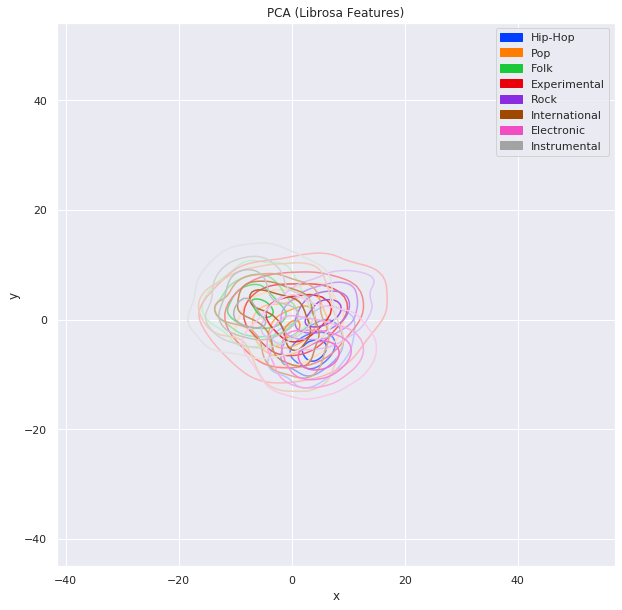

PCA took 0.01s


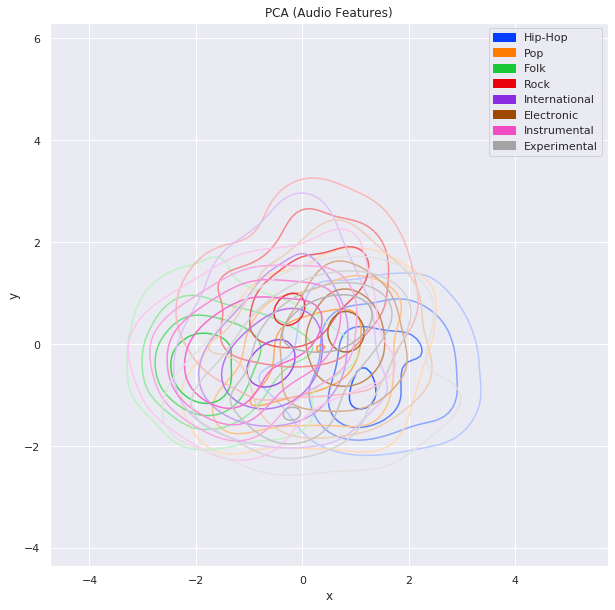

PCA took 0.02s


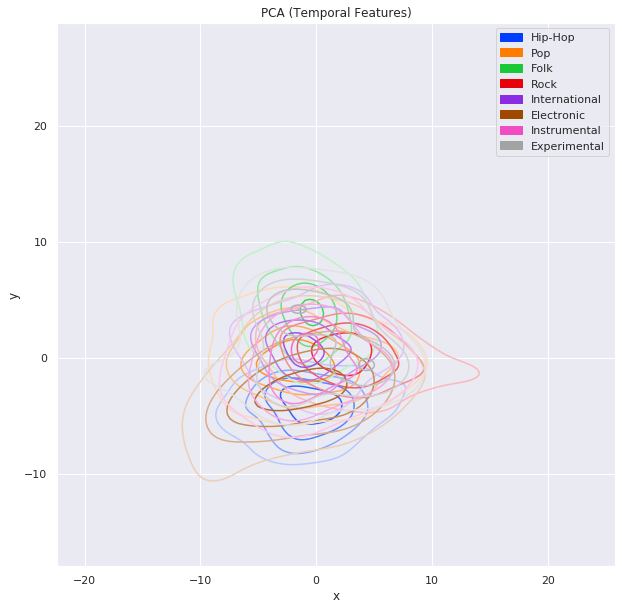

In [16]:
pca = reduce_pca(data, "librosa_features", "genre")
plot_clusters(pca, title="PCA (Librosa Features)")
pca = reduce_pca(data[data["has_echonest"]], "audio_features", "genre")
plot_clusters(pca, title="PCA (Audio Features)")
pca = reduce_pca(data[data["has_echonest"]], "temporal_features", "genre")
plot_clusters(pca, title="PCA (Temporal Features)")

UMAP took 5.36s


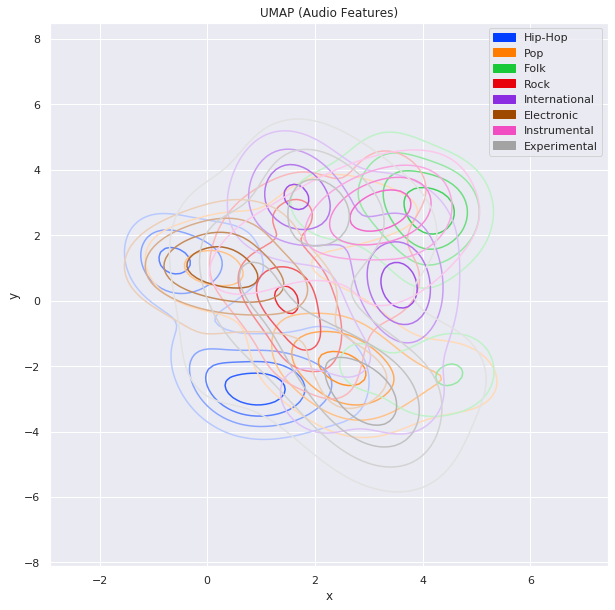

UMAP took 3.26s


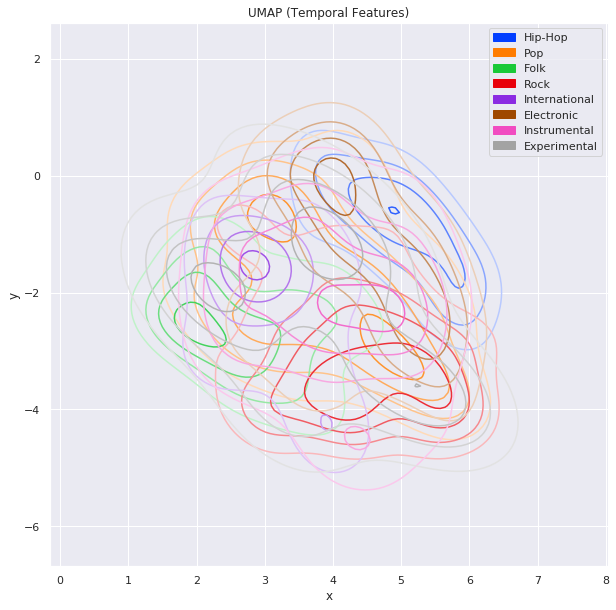

/opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

UMAP took 101.00s


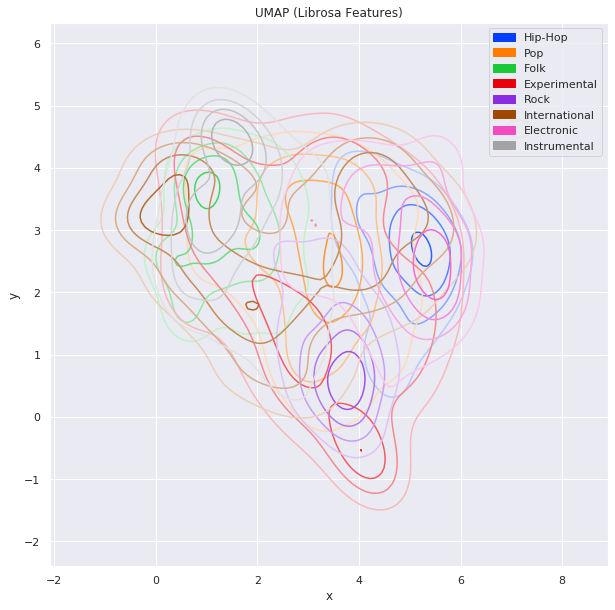

In [17]:
umap = reduce_umap(data[data["has_echonest"]], "audio_features", "genre")
plot_clusters(umap, title=f"UMAP (Audio Features)")
umap = reduce_umap(data[data["has_echonest"]], "temporal_features", "genre")
plot_clusters(umap, title=f"UMAP (Temporal Features)")
umap = reduce_umap(data, "librosa_features", "genre")
plot_clusters(umap, title=f"UMAP (Librosa Features)")